In [113]:
import pandas as pd
import torch
import torch.nn.functional as F
from StockAnomaly import StockAnomaly
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


from transformers import (AutoModelForSequenceClassification,
                          pipeline,
                          AutoTokenizer)

data = pd.read_parquet('scraped_data.parquet')

# data = data[data.datetime>='2023-01-01']

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
BERTmodel = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('text-classification',model=BERTmodel,tokenizer=tokenizer,truncation=True, max_length=512)

def finbert_sentiment(text:str) -> tuple[float,float,float,str]:
    '''https://www.youtube.com/watch?v=FRDKeNEeNAQ&t=640s'''
    with torch.no_grad():
 
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512     
        )
        
        inputs = {k: v.to(BERTmodel.device) for k, v in inputs.items()}

        outputs = BERTmodel(**inputs)
        
        probs = F.softmax(outputs.logits, dim=-1).squeeze()
        
        id2label = BERTmodel.config.id2label
        scores = {id2label[i]: probs[i].item() for i in range(len(id2label))}

        return (scores['positive'],scores['neutral'],scores['negative'],max(scores,key=scores.get))

def calc_bullishness(group_series):
    """
    Antweiler & Frank (2004) Bullishness Index: B = ln((1 + N_pos) / (1 + N_neg))
    Input: A Series of sentiment labels ('positive', 'neutral', 'negative')
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    
    return np.log((1 + n_pos) / (1 + n_neg))

def calc_agreement(group_series):
    """
    Antweiler & Frank (2004) Agreement Index:
    Measures consensus. Higher value = High consensus (everyone agrees).
    Lower value = High disagreement or mostly neutral news.
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    n_neut = counts.get('neutral', 0)
    
    total = n_pos + n_neg + n_neut
    
    if total == 0:
        return 0.0
    
    inner_val = ((n_pos - n_neg) / total) ** 2
    agreement = 1 - np.sqrt(1 - inner_val)
    
    return agreement

def compute_volatility(df):

    # MA 1

    model = ARIMA(df['log_return'], order=(0, 0, 1))
    model_fit = model.fit()    

    df['ln_vi_t'] = np.log(model_fit.resid**2)

    df['ln_vi_t_soxx'] = np.log((df['log_return']-df['soxx_ret'])**2)
    
    return df

def add_ts(metrics):
    stocks = ["AMD", "ASML", "GOOG", "META", "NVDA"]

    stocks_data = yf.Tickers(stocks)
    hist = stocks_data.history(period='3y', interval="1d")
    
    data_subset = hist[['Close', 'Volume', 'Dividends']]
    prices_long = data_subset.stack(level=1).reset_index()
    prices_long.columns = ['date', 'label', 'price', 'volume', 'dividend']

    prices_long['dividend_dummy'] = np.where(prices_long['dividend'] > 0, 1, 0)
    
    prices_long = prices_long.sort_values(['label', 'date'])

    prices_long['log_return'] = prices_long.groupby('label')['price'].transform(
        lambda x: 100*np.log(x/x.shift(1))
    )
    
    prices_long['log_return_lag'] = prices_long.groupby('label')['log_return'].shift(1)
    prices_long['lag_neg'] = np.where(prices_long['log_return_lag']<0,1,0)

    prices_long['log_volume'] = np.log(prices_long['volume'])
    prices_long['log_volume_lag'] = prices_long.groupby('label')['log_volume'].shift(1)

    prices_long['date'] = prices_long['date'].dt.strftime('%Y-%m-%d')

    soxx = yf.Ticker("SOXX").history(period='5y')[['Close']]
    soxx['soxx_ret'] = 100*np.log(soxx['Close']/soxx['Close'].shift(1))
    soxx.index = pd.to_datetime(soxx.index.date).strftime('%Y-%m-%d')
    soxx = soxx[['soxx_ret']].reset_index().rename(columns={'index': 'date'})

    combined_df = prices_long.merge(metrics, on=['date', 'label'], how='left')
    combined_df = combined_df.merge(soxx, on='date', how='left')

    combined_df['bullishness_lag'] = combined_df.groupby('label')['bullishness_index'].shift(1)
    combined_df['agreement_lag'] = combined_df.groupby('label')['agreement_index'].shift(1)
    combined_df['article_count_lag'] = combined_df.groupby('label')['article_count'].shift(1)
    combined_df['soxx_ret_lag'] = combined_df.groupby('label')['soxx_ret'].shift(1)


    combined_df = combined_df.dropna()

    combined_df.sort_values('date',ascending=True,inplace=True)

    combined_df = combined_df.groupby('label', group_keys=False).apply(compute_volatility)

    return combined_df



Device set to use cuda:0


# FINBERT
- We took the first paragrah as the scraped articles as it contains a summary of the article itself.
- Finbert gives probabilities to the article, whether it is positive/negative/neutral, and assign a sentiment according to the highest assigned probabilty.
- we took article which assigned sentiment is higher than 0.5
# Sentiment
- We replicate two indicators from a popular paper of Antweiler & Frank (2004).
    - Bullishness Index: Mood of the news. can be either above or below 0
    - Agreement Index: Measure consensus in articles. ranges from 0 to 1.
# Features Engineering
- log_returns = 100\*ln(pt/pt-1): we multiply by 100 for models stability
- log_volume = we took ln of the volume to stabilize the data 
- we create lagged variables for most each stock: bullishness_lag, agreement_lag, etc
# Volatility Computation (ln_vi_t)
- We use the same logic as in the paper to compute the daily volatilty. for each stock, we compute a MA(1) for the log_return, and we take the log of squared the residuals. In this way we clean for short term noise. the idea is that we are mimiking the *bid-ask bounce* of the paper. (they are using intraday data that we do not have)
- In this way we get the portion of a stock's price fluctuation that is unique to that specific company.


In [114]:
SENTIMENT_REF_COLUMN = 'fist_parag'

data[['fb_positive','fb_neutral','fb_negative','sentiment']] = data[SENTIMENT_REF_COLUMN].apply(finbert_sentiment).apply(pd.Series)


In [115]:
# compute metrics i.e. market bullishness and agreement
data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)

# filter for certain articles

TRESHOLD = 0.5
cond = (
    ((data['fb_positive']>TRESHOLD) & (data['sentiment']=='positive')) |
    ((data['fb_neutral']>TRESHOLD) & (data['sentiment']=='neutral')) |
    ((data['fb_negative']>TRESHOLD) & (data['sentiment']=='negative'))
)

metrics = data[cond].groupby(['label','date'],as_index=False)['sentiment'].agg(
    bullishness_index = calc_bullishness,
    agreement_index = calc_agreement,
    article_count = 'count'
)

clean_data = add_ts(metrics)
clean_data.head(2)

/tmp/ipykernel_7746/3837125503.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)
[*********************100%***********************]  5 of 5 completed
/tmp/ipykernel_7746/812011730.py:98: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  prices_long = data_subset.stack(level=1).reset_index()
/home/leonardo/Public/projects/T&M-assignment2/tam_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supporte

,date,label,price,volume,dividend,dividend_dummy,log_return,log_return_lag,lag_neg,log_volume,...,bullishness_index,agreement_index,article_count,soxx_ret,bullishness_lag,agreement_lag,article_count_lag,soxx_ret_lag,ln_vi_t,ln_vi_t_soxx
2264,2023-01-19,META,135.205536,28625200,0.0,0,2.325764,-1.743824,1,17.169798,...,0.000000,0.0,2.0,-2.845470,-0.693147,1.0,1.0,-0.526423,1.500784,3.286223
2265,2023-01-20,META,138.403183,28688600,0.0,0,2.337493,2.325764,0,17.172010,...,-1.609438,1.0,4.0,3.081787,0.000000,0.0,2.0,-2.845470,1.541403,-0.590640


In [116]:
clean_data.columns

Index(['date', 'label', 'price', 'volume', 'dividend', 'dividend_dummy',
       'log_return', 'log_return_lag', 'lag_neg', 'log_volume',
       'log_volume_lag', 'bullishness_index', 'agreement_index',
       'article_count', 'soxx_ret', 'bullishness_lag', 'agreement_lag',
       'article_count_lag', 'soxx_ret_lag', 'ln_vi_t', 'ln_vi_t_soxx'],
      dtype='object')

# Volatility Analysis

- we attempted to **broadly** replicate paper's finding and regression.
- we use the following variables to predict the volatility:
    - agreement_t-1
    - article_count_t-1
    - lag_neg: at t-1 we have negative returns
    - log_volume_t-1: volume traded in t-1, in the paper they find that it is important for volatility. Howoever they use log_volume_t. We used volatility as time t-1 to avoid simultaineity bias as volume and volatily move together.
## Results
- Agreement Index: The positive coefficient (0.6794) indicates that high consensus among journalists leads to higher volatility. In professional news, agreement signals a "coordinated information shock" that triggers massive trading.
- Article Count: Unlike previous runs, news quantity is now significant. More articles yesterday = higher volatility today. This supports the "Attention Theory"—as news coverage intensifies, more investors are drawn to the stock, increasing fluctuations.
- Negative return: If the stock went down yesterday, investors are more "jittery" today, leading to higher volatility than if the stock had gone up.
- Volume (AKA TRADING ACTIVITY): As in the paper it is a relevant control and provide additional informations

# Papper

In [135]:
# volatility as in the paper
X_returns = clean_data[['agreement_lag',
                        'article_count_lag',
                        'lag_neg',
                        'log_volume_lag'
                        ]]
X_returns = sm.add_constant(X_returns)
y_returns = clean_data['ln_vi_t']

model_returns = sm.OLS(y_returns, X_returns).fit()
print(model_returns.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_vi_t   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     11.10
Date:                Sun, 18 Jan 2026   Prob (F-statistic):           6.53e-09
Time:                        14:46:22   Log-Likelihood:                -4996.8
No. Observations:                2204   AIC:                         1.000e+04
Df Residuals:                    2199   BIC:                         1.003e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.7116      0.64

/tmp/ipykernel_7746/2464966745.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='agreement_group',


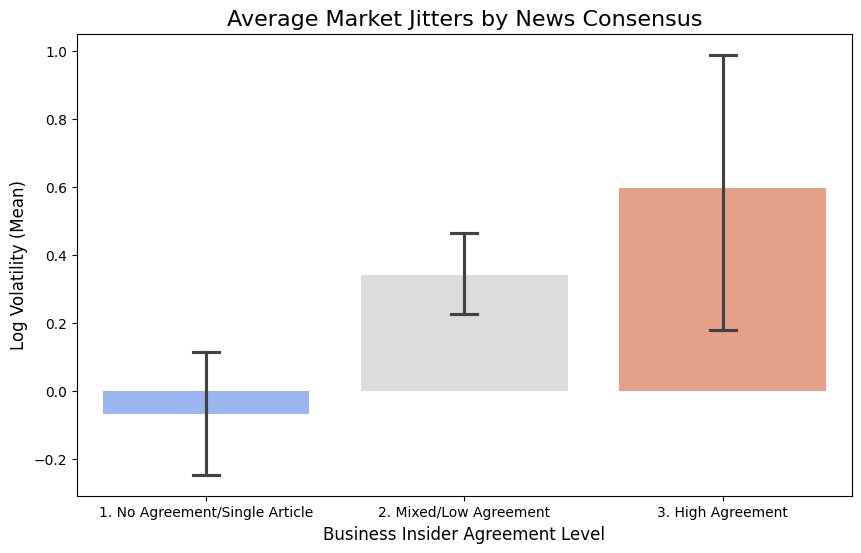

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create 3 simple categories manually to avoid the qcut error
def categorize_agreement(x):
    if x == 0: return "1. No Agreement/Single Article"
    if x < 0.5: return "2. Mixed/Low Agreement"
    return "3. High Agreement"

clean_data['agreement_group'] = clean_data['agreement_lag'].apply(categorize_agreement)

plt.figure(figsize=(10, 6))
sns.barplot(x='agreement_group',
            y='ln_vi_t',
            data=clean_data,
            palette='coolwarm',
            capsize=.1,
            order=[
    "1. No Agreement/Single Article", 
    "2. Mixed/Low Agreement", 
    "3. High Agreement"
        ])

plt.title('Average Market Jitters by News Consensus', fontsize=16)
plt.xlabel('Business Insider Agreement Level', fontsize=12)
plt.ylabel('Log Volatility (Mean)', fontsize=12)
plt.show()

In [120]:
stock_anomaly = StockAnomaly()

stock_anomaly.calculate(window=20,price_z=2,volume_z=2)

anomalies = stock_anomaly.get_anomalies()
anomalies['date'] = anomalies['date'].dt.strftime('%Y-%m-%d')
anomalies['high_volatility'] = int(1)

[*********************100%***********************]  5 of 5 completed


In [121]:
anomalies

index,date,stock,rolling_z_P,rolling_z_V,high_volatility
0,2021-04-12,AMD,-2.105441,2.868881,1
1,2021-04-15,AMD,2.059740,2.757991,1
2,2021-06-17,AMD,2.947586,3.424378,1
3,2021-07-28,AMD,2.792344,3.648379,1
4,2021-09-28,AMD,-3.029134,3.302819,1
...,...,...,...,...,...
127,2024-09-03,NVDA,-2.297107,2.068591,1
128,2025-01-07,NVDA,-2.193408,2.299801,1
129,2025-01-27,NVDA,-3.374747,4.007964,1
130,2025-02-27,NVDA,-2.527289,2.194220,1


In [122]:

merged_data = clean_data.merge(anomalies[['date','stock','high_volatility']],
                              how='left',
                              left_on = ['date', 'label'],
                              right_on = ['date','stock'])

In [123]:
merged_data.drop(columns='stock',inplace=True)
merged_data['high_volatility'] = merged_data['high_volatility'].fillna(0)
merged_data['high_vol_tmrrw'] = merged_data['high_volatility'].shift(-1)

merged_data.dropna(inplace=True)

In [124]:
# weighting
n_total = len(merged_data)
n_events = merged_data['high_volatility'].sum()
n_normal = n_total - n_events

# Weight for the rare event (Class 1) and normal day (Class 0)
weight_event = n_total / (2 * n_events)
weight_normal = n_total / (2 * n_normal)

weights = merged_data['high_volatility'].apply(lambda x: weight_event if x == 1 else weight_normal)
weights

0       0.512326
1       0.512326
2       0.512326
3       0.512326
4       0.512326
          ...   
2198    0.512326
2199    0.512326
2200    0.512326
2201    0.512326
2202    0.512326
Name: high_volatility, Length: 2203, dtype: float64

In [132]:
import statsmodels.api as sm

pred = ['bullishness_lag',
        'agreement_lag',
        'article_count_lag',
        'lag_neg',
        'log_volume_lag']

predictors = sm.add_constant(
    merged_data[pred]
)

weighted_model = sm.GLM(merged_data['high_volatility'], predictors,
                        family=sm.families.Binomial(), freq_weights=weights).fit()

print(weighted_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        high_volatility   No. Observations:                 2203
Model:                            GLM   Df Residuals:                     2197
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1512.8
Date:                Sun, 18 Jan 2026   Deviance:                       3025.5
Time:                        13:08:40   Pearson chi2:                 2.20e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01284
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.0475      0.52